In [1]:
import torch
import torchvision
from torch import optim
from model import *
import json

with open('config.json') as f:
    args = json.load(f)

n_epochs = args["n_epochs"]
batch_size_train = args["batch_size_train"]
batch_size_test = args["batch_size_test"]
learning_rate = args["learning_rate"]
momentum = args["momentum"]
log_interval = args["log_interval"]

In [2]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [3]:
# model = VAE()
# model.load_state_dict(torch.load("vae.pt"))
# model = IW_VAE()
# model.load_state_dict(torch.load("iw-vae.pt"))
# model = GMVAE()
# model.load_state_dict(torch.load("gmvae.pt"))
model = IW_GMVAE()
model.load_state_dict(torch.load("iw-gmvae.pt"))

model.cuda()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-9)

In [4]:
z_lst, labels_pred = [], []

for i, x in enumerate(test_loader):
    print("Test Batch {} / {}".format(i + 1, len(test_loader)), end="\r")
    img, labels = x
    img, labels = img.cuda(), labels.cuda()
    img_hat, z, mu, var, log_logits_z, cls_z_prob = model.evaluate(img)
    z_lst.append(z)
    labels_pred.append(torch.argmax(cls_z_prob, dim=-1))

z_lst = torch.cat(z_lst, dim=0)
labels_pred = torch.cat(labels_pred, dim=0)

print(z_lst.shape, labels_pred.shape)

torch.Size([10000, 64]) torch.Size([10000])


In [5]:
from sklearn.manifold import TSNE
import seaborn as sns
sns.set()

In [6]:
tsne = TSNE(n_components=2, verbose=3)  #metric='manhattan'
tsne_features = tsne.fit_transform(z_lst.cpu().detach().numpy())
color = labels_pred.cpu().detach().numpy()
palette = sns.color_palette("bright", len(set(color)))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.035s...
[t-SNE] Computed neighbors for 10000 samples in 4.782s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.049592
[t-SNE] Computed conditional probabilities in 0.653s
[t-SNE] Iteration 50: error = 95.6147690, gradient norm = 0.0135966 (50 iterations in 7.363s)
[t-SNE] It

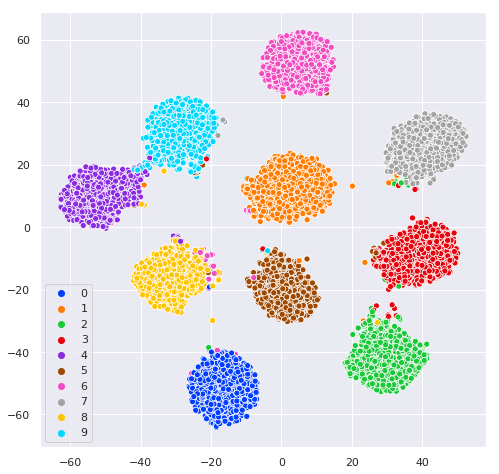

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,8))
sns.scatterplot(tsne_features[:,0], tsne_features[:,1], palette=palette, hue=color, legend='full')